In [78]:
#! /usr/bin/python3

__author__ = "Jun Hu <jh3846@columbia.edu"
__date__ = "Apr 10, 2018"

import logging

logger = logging.getLogger('etl')
logger.setLevel(logging.DEBUG)

ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)

formatter_c = logging.Formatter('[%(asctime)s]-[%(process)d]-[%(thread)d]-[%(name)s]-[%(lineno)s]-[%(levelname)s]: %(message)s')
ch.setFormatter(formatter_c)

logger.addHandler(ch)

import pandas as pd
import time

from sklearn.feature_extraction.text import TfidfVectorizer

import numpy as np

from keras.models import Sequential
import keras.backend as K
from keras.layers import Dense
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.utils.vis_utils import plot_model
from keras import regularizers, optimizers
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df1 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d1.pickle")
df2 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d2.pickle")
df3 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d3.pickle")
df4 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d4.pickle")
df5 = pd.read_pickle("/Users/junhu/Projects/bcr_data/d5.pickle")

In [3]:
df = pd.concat([df1, df2, df3, df4, df5], axis=1)
logger.debug(df.shape)
df.head()

[2018-04-25 10:18:55,248]-[22022]-[140735658623872]-[etl]-[2]-[DEBUG]: (4241, 17)


,cancer,unigram,bigram,trigram,four_gram,five_gram,six_gram,trigram_skip2,trigram_skip3,unigram_cls,bigram_cls,trigram_cls,four_gram_cls,five_gram_cls,six_gram_cls,trigram_cls_skip2,trigram_cls_skip3
0,THCA,D Y W G Q G R S D D T A V Y F C G D S P P F F ...,DY YW WG GQ QG RS SD DD DT TA AV VY YF FC GD D...,DYW YWG WGQ GQG RSD SDD DDT DTA TAV AVY VYF YF...,DYWG YWGQ WGQG RSDD SDDT DDTA DTAV TAVY AVYF V...,DYWGQ YWGQG RSDDT SDDTA DDTAV DTAVY TAVYF AVYF...,DYWGQG RSDDTA SDDTAV DDTAVY DTAVYF TAVYFC GDSP...,DWQ YGG RDT SDA DTV DAY TVF AYC GSP DPF SPF PF...,RTF SAC GPY DFW SFG PDQ PYG RTF SAC DVA DYR TF...,4 Y W G 5 G 6 3 4 4 3 1 1 Y F 2 G 4 3 P P F F ...,4Y YW WG G5 5G 63 34 44 43 31 11 1Y YF F2 G4 4...,4YW YWG WG5 G5G 634 344 443 431 311 11Y 1YF YF...,4YWG YWG5 WG5G 6344 3443 4431 4311 311Y 11YF 1...,4YWG5 YWG5G 63443 34431 44311 4311Y 311YF 11YF...,4YWG5G 634431 344311 44311Y 4311YF 311YF2 G43P...,4W5 YGG 643 341 431 41Y 31F 1Y2 G3P 4PF 3PF PF...,63F 312 GPY 4FW 3FG P45 PYG 63F 312 411 4Y6 3F...
1,LUSC,Y Y C A R G V V Y Y C A R V G Y Y Y D S S D Y ...,YY YC CA AR RG GV VV YY YC CA AR RV VG GY YY Y...,YYC YCA CAR ARG RGV GVV YYC YCA CAR ARV RVG VG...,YYCA YCAR CARG ARGV RGVV YYCA YCAR CARV ARVG R...,YYCAR YCARG CARGV ARGVV YYCAR YCARV CARVG ARVG...,YYCARG YCARGV CARGVV YYCARV YCARVG CARVGY ARVG...,YCR YAG CRV AGV YCR YAV CRG AVY RGY VYY GYD YY...,YRY YVY CGD AYS RYS VYD GDY YSP YSM YSL CLR AW...,Y Y 2 1 6 G 1 1 Y Y 2 1 6 1 G Y Y Y 4 3 3 4 Y ...,YY Y2 21 16 6G G1 11 YY Y2 21 16 61 1G GY YY Y...,YY2 Y21 216 16G 6G1 G11 YY2 Y21 216 161 61G 1G...,YY21 Y216 216G 16G1 6G11 YY21 Y216 2161 161G 6...,YY216 Y216G 216G1 16G11 YY216 Y2161 2161G 161G...,YY216G Y216G1 216G11 YY2161 Y2161G 2161GY 161G...,Y26 Y1G 261 1G1 Y26 Y11 26G 11Y 6GY 1YY GY4 YY...,Y6Y Y1Y 2G4 1Y3 6Y3 1Y4 G4Y Y3P Y32 Y31 216 1W...
2,OV,R E H S S S S W Y F D Y W G Q G Y Y C A R H E ...,RE EH HS SS SS SS SW WY YF FD DY YW WG GQ QG Y...,REH EHS HSS SSS SSS SSW SWY WYF YFD FDY DYW YW...,REHS EHSS HSSS SSSS SSSW SSWY SWYF WYFD YFDY F...,REHSS EHSSS HSSSS SSSSW SSSWY SSWYF SWYFD WYFD...,REHSSS EHSSSS HSSSSW SSSSWY SSSWYF SSWYFD SWYF...,RHS ESS HSS SSW SSY SWF SYD WFY YDW FYG DWQ YG...,RSY ESF HSD SWY SYW SFG SDQ WYG YRG YHQ CES AD...,6 4 6 3 3 3 3 W Y F 4 Y W G 5 G Y Y 2 1 6 6 4 ...,64 46 63 33 33 33 3W WY YF F4 4Y YW WG G5 5G Y...,646 463 633 333 333 33W 3WY WYF YF4 F4Y 4YW YW...,6463 4633 6333 3333 333W 33WY 3WYF WYF4 YF4Y F...,64633 46333 63333 3333W 333WY 33WYF 3WYF4 WYF4...,646333 463333 63333W 3333WY 333WYF 33WYF4 3WYF...,663 433 633 33W 33Y 3WF 3Y4 WFY Y4W FYG 4W5 YG...,63Y 43F 634 3WY 3YW 3FG 345 WYG Y6G Y65 243 14...
3,COAD,D Y Y F D Y W G Q G Y Y C A R E P N G P A Y Y ...,DY YY YF FD DY YW WG GQ QG YY YC CA AR RE EP P...,DYY YYF YFD FDY DYW YWG WGQ GQG YYC YCA CAR AR...,DYYF YYFD YFDY FDYW DYWG YWGQ WGQG YYCA YCAR C...,DYYFD YYFDY YFDYW FDYWG DYWGQ YWGQG YYCAR YCAR...,DYYFDY YYFDYW YFDYWG FDYWGQ DYWGQG YYCARE YCAR...,DYD YFY YDW FYG DWQ YGG YCR YAE CRP AEN RPG EN...,DDQ YYG YRG YEP AYV YGW YMG YDQ YVG DYK TYE AY...,4 Y Y F 4 Y W G 5 G Y Y 2 1 6 4 P 5 G P 1 Y Y ...,4Y YY YF F4 4Y YW WG G5 5G YY Y2 21 16 64 4P P...,4YY YYF YF4 F4Y 4YW YWG WG5 G5G YY2 Y21 216 16...,4YYF YYF4 YF4Y F4YW 4YWG YWG5 WG5G YY21 Y216 2...,4YYF4 YYF4Y YF4YW F4YWG 4YWG5 YWG5G YY216 Y216...,4YYF4Y YYF4YW YF4YWG F4YWG5 4YWG5G YY2164 Y216...,4Y4 YFY Y4W FYG 4W5 YGG Y26 Y14 26P 145 6PG 45...,445 YYG Y6G Y4P 1Y1 YGW Y2G Y45 Y1G 4Y6 3Y4 1Y...
4,THCA,Y S S G S T L D Y W G Q G Y Y Y G M D V W G Q ...,YS SS SG GS ST TL LD DY YW WG GQ QG YY YY YG G...,YSS SSG SGS GST STL TLD LDY DYW YWG WGQ GQG YY...,YSSG SSGS SGST GSTL STLD TLDY LDYW DYWG YWGQ W...,YSSGS SSGST SGSTL GSTLD STLDY TLDYW LDYWG DYWG...,YSSGST SSGSTL SGSTLD GSTLDY STLDYW TLDYWG LDYW...,YSS SGT SSL GTD SLY TDW LYG DWQ YGG YYM YGD YM...,YSY STW SLG GDQ SYG YMG YDQ YVG EYV TGW NMG YD...,Y 3 3 G 3 3 1 4 Y W G 5 G Y Y Y G 2 4 1 W G 5 ...,Y3 33 3G G3 33 31 14 4Y YW WG G5 5G YY YY YG G...,Y33 33G 3G3 G33 331 314 14Y 4YW YWG WG5 G5G YY...,Y33G 33G3 3G33 G3

In [5]:
start_time = time.time()

df_vec4000 = df.copy()
max_features = 4000

# ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')

for i in range(1, 17):
    start_time1 = time.time()
    df_vec4000.iloc[:, i] = tfidf.fit_transform(df_vec4000.iloc[:, i]).toarray().tolist()
    logger.debug("--- %s seconds ---" % (time.time() - start_time1))
logger.debug("--- %s seconds ---" % (time.time() - start_time))
df_vec4000.to_pickle("/Users/junhu/Projects/bcr_data/df_vec4000.pickle")



[2018-04-25 11:15:19,699]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 76.75185108184814 seconds ---


[2018-04-25 11:16:53,194]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 93.47376084327698 seconds ---


[2018-04-25 11:18:36,356]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 103.15917897224426 seconds ---


[2018-04-25 11:20:43,553]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 127.19161915779114 seconds ---


[2018-04-25 11:23:21,043]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 157.48258709907532 seconds ---


[2018-04-25 11:29:04,863]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 343.8124759197235 seconds ---


[2018-04-25 11:30:59,281]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 114.41038990020752 seconds ---


[2018-04-25 11:32:18,341]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 79.0519049167633 seconds ---


[2018-04-25 11:33:58,489]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 100.13671517372131 seconds ---


[2018-04-25 11:36:10,731]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 132.23745489120483 seconds ---


[2018-04-25 11:38:15,154]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 124.40299201011658 seconds ---


[2018-04-25 11:43:27,356]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 312.19010305404663 seconds ---


[2018-04-25 11:45:54,839]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 147.4755940437317 seconds ---


[2018-04-25 11:48:23,592]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 148.74259400367737 seconds ---


[2018-04-25 11:50:03,558]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 99.95715475082397 seconds ---


[2018-04-25 11:50:57,879]-[22022]-[140735658623872]-[etl]-[12]-[DEBUG]: --- 54.31193494796753 seconds ---


[2018-04-25 11:50:57,915]-[22022]-[140735658623872]-[etl]-[13]-[DEBUG]: --- 2261.245082139969 seconds ---


In [5]:
# start_time = time.time()
# 
# df_vec10000 = df.copy()
# max_features = 10000
# 
# # ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
# tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')
# 
# for i in range(1, 17):
#     start_time1 = time.time()
#     df_vec10000.iloc[:, i] = tfidf.fit_transform(df_vec10000.iloc[:, i]).toarray().tolist()
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# logger.debug("--- %s seconds ---" % (time.time() - start_time))
# 
# df_vec10000.to_pickle(r"F:\courses\bcr_data\df_vec10000.pickle")

[2018-04-24 19:54:01,722]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 75.05780625343323 seconds ---


[2018-04-24 19:55:24,654]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 82.93081402778625 seconds ---


[2018-04-24 19:56:46,521]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 81.864905834198 seconds ---


[2018-04-24 19:58:21,999]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 95.47649383544922 seconds ---


[2018-04-24 20:05:33,854]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 431.85456562042236 seconds ---


[2018-04-24 20:15:45,171]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 611.3135178089142 seconds ---


[2018-04-24 20:19:55,574]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 250.4016752243042 seconds ---


[2018-04-24 20:21:05,720]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 70.14262890815735 seconds ---


[2018-04-24 21:02:35,201]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 2489.479713201523 seconds ---


[2018-04-24 21:07:49,722]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 314.5038962364197 seconds ---


[2018-04-24 21:12:28,719]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 278.69273853302 seconds ---


[2018-04-24 21:15:17,014]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 168.2946493625641 seconds ---


[2018-04-24 21:19:15,221]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 238.20289039611816 seconds ---


[2018-04-24 21:22:05,068]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 169.8456814289093 seconds ---


[2018-04-24 21:26:50,152]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 285.0818667411804 seconds ---


[2018-04-24 21:27:51,585]-[5244]-[8988]-[etl]-[12]-[DEBUG]: --- 61.430301904678345 seconds ---


[2018-04-24 21:27:51,591]-[5244]-[8988]-[etl]-[13]-[DEBUG]: --- 5704.9492337703705 seconds ---


In [4]:
# start_time = time.time()
# 
# df_model = df.copy()
# 
# df_model["all_features_str"] = df_model.iloc[:, 1]
# for i in range(0, 17):
#     start_time1 = time.time()
#     df_model["all_features_str"] = df_model["all_features_str"] + df_model.iloc[:, i]
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# max_features = 100
# 
# # ou can change the token_pattern parameter from (?u)\\b\\w\\w+\\b (default) to (?u)\\b\\w\\w*\\b; The default matches token that has two or more word characters (in case you are not familiar with regex, + means one or more, so \\w\\w+ matches word with two or more word characters; * on the other hand means zero or more, \\w\\w* will thus match word with one or more characters):
# for max_features in range(2000, 10000, 2000):
#     start_time1 = time.time()
#     tfidf = TfidfVectorizer(max_features=max_features, stop_words=None, lowercase=False, token_pattern='(?u)\\b\\w\\w*\\b')
#     df_model.iloc["all_features_{}".format(max_features)] = tfidf.fit_transform(df_model.all_features_str).toarray().tolist()
#     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# 
# # for i in range(1, 17):
# # #     start_time1 = time.time()
# # #     df_vec100.iloc[:, i] = tfidf.fit_transform(df_vec100.iloc[:, i]).toarray().tolist()
# # #     logger.debug("--- %s seconds ---" % (time.time() - start_time1))
# logger.debug("--- %s seconds ---" % (time.time() - start_time))
# # df_vec100.to_pickle(r"F:\courses\bcr_data\df_vec100.pickle")

[2018-04-25 10:19:39,950]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 2.0253171920776367 seconds ---


[2018-04-25 10:19:41,113]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 1.1623561382293701 seconds ---


[2018-04-25 10:19:47,738]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 6.623291015625 seconds ---


[2018-04-25 10:19:57,229]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 9.484586000442505 seconds ---


[2018-04-25 10:20:10,414]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 13.177716970443726 seconds ---


[2018-04-25 10:20:36,685]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 26.264261960983276 seconds ---


[2018-04-25 10:21:22,849]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 46.155609130859375 seconds ---


[2018-04-25 10:22:16,324]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 53.46981191635132 seconds ---


[2018-04-25 10:23:17,817]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 61.47909927368164 seconds ---


[2018-04-25 10:24:19,292]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 61.46058201789856 seconds ---


[2018-04-25 10:25:40,509]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 81.20649719238281 seconds ---


[2018-04-25 10:27:17,392]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 96.87248730659485 seconds ---


[2018-04-25 10:29:09,584]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 112.18130588531494 seconds ---


[2018-04-25 10:31:35,751]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 146.14876890182495 seconds ---


[2018-04-25 10:34:38,531]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 182.76044702529907 seconds ---


[2018-04-25 10:38:05,329]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 206.78540229797363 seconds ---


[2018-04-25 10:42:14,142]-[22022]-[140735658623872]-[etl]-[9]-[DEBUG]: --- 248.7958903312683 seconds ---


ValueError: Can only index by location with a [integer, integer slice (START point is INCLUDED, END point is EXCLUDED), listlike of integers, boolean array]

In [6]:
# summarize history for loss
def plot_loss():
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('loss1.png')
    plt.show()

# summarize history for acc
def plot_acc():
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('acc1.png')
    plt.show()

In [7]:
# df_model = pd.read_pickle(r"F:\courses\bcr_data\df_vec10000.pickle")
df_model = df_vec4000

In [8]:
list(df_model)

['cancer',
 'unigram',
 'bigram',
 'trigram',
 'four_gram',
 'five_gram',
 'six_gram',
 'trigram_skip2',
 'trigram_skip3',
 'unigram_cls',
 'bigram_cls',
 'trigram_cls',
 'four_gram_cls',
 'five_gram_cls',
 'six_gram_cls',
 'trigram_cls_skip2',
 'trigram_cls_skip3']

In [76]:
# df_model["all_features"] = df_model.iloc[:, 1]
# for i in range(6, 7):
#     df_model["all_features"] = df_model["all_features"] + df_model.iloc[:, i]

features = ['cancer',
            'unigram',
            'bigram',
            'trigram',
            'four_gram',
            'five_gram',
            'six_gram',
            'trigram_skip2',
            'trigram_skip3',
            'unigram_cls',
            'bigram_cls',
            'trigram_cls',
            'four_gram_cls',
            'five_gram_cls',
            'six_gram_cls',
            'trigram_cls_skip2',
            'trigram_cls_skip3']

df_model["all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls + df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 + df_model.five_gram + df_model.six_gram + df_model.five_gram_cls + df_model.six_gram_cls

# df_model["all_features"] = df_model.trigram + df_model.trigram_cls + df_model.four_gram + df_model.four_gram_cls + df_model.trigram_skip2 + df_model.trigram_skip3 + df_model.trigram_cls_skip2 + df_model.trigram_cls_skip3 

# df_model["all_features"] = df_model.unigram + df_model.bigram + df_model.unigram_cls + df_model.bigram_cls

X = np.array(list(df_model.all_features)).astype(float)
Y = np.array(list(df_model.cancer))
logger.debug(len(X[0]))

encoder = LabelEncoder()
encoder.fit(Y)
encoder_Y = encoder.transform(Y)
dummy_y = np_utils.to_categorical(encoder_Y)
logger.debug(dummy_y[0])


[2018-04-25 17:08:11,756]-[22022]-[140735658623872]-[etl]-[31]-[DEBUG]: 40545


[2018-04-25 17:08:11,914]-[22022]-[140735658623872]-[etl]-[37]-[DEBUG]: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


In [79]:
seed = 23
np.random.seed(23)
dim = len(X[0])

# , kernel_regularizer=regularizers.l2(0.0001), activity_regularizer=regularizers.l1(0.0001)
K.clear_session()
model = Sequential()
model.add(Embedding(1000,
                        50, #!!!!!!!!!!!!!!!!!!!!!!!
                        input_length=dim))
# model.add(Dense(2000, input_dim=dim, activation="relu"))
model.add(Dropout(0.5))
model.add(Conv1D(64,
                     3,
                     padding='valid',
                     activation='relu',
                     strides=1))
model.add(GlobalMaxPooling1D())
model.add(Dense(1000, activation="relu", kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))
model.add(Dense(13, activation="softmax"))
Adam = optimizers.adam(lr=0.001)
model.compile(loss="categorical_crossentropy", optimizer=Adam, metrics=["accuracy"])
# plot_model(model, to_file="/model/model.png", show_shapes=True, show_layer_names=True)
model.summary()
early_stop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
history = model.fit(X, dummy_y, validation_split=0.5, epochs=300, batch_size=256, callbacks=[early_stop])

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40545, 50)         50000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 40545, 50)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 40543, 64)         9664      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              65000     
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                13013     
Total para

Train on 2120 samples, validate on 2121 samples
Epoch 1/300


 256/2120 [==>...........................] - ETA: 11:33 - loss: 2.6856 - acc: 0.0820

 512/2120 [======>.......................] - ETA: 9:54 - loss: 2.6826 - acc: 0.0918 

 768/2120 [=========>....................] - ETA: 8:09 - loss: 2.6767 - acc: 0.0938

1024/2120 [=============>................] - ETA: 6:30 - loss: 2.6759 - acc: 0.0898

1280/2120 [=================>............] - ETA: 4:54 - loss: 2.6719 - acc: 0.0914

1536/2120 [====================>.........] - ETA: 3:24 - loss: 2.6684 - acc: 0.0924

1792/2120 [========================>.....] - ETA: 1:54 - loss: 2.6655 - acc: 0.0926

2048/2120 [===========================>..] - ETA: 25s - loss: 2.6625 - acc: 0.0933 

2120/2120 [==============================] - 874s 412ms/step - loss: 2.6615 - acc: 0.0948 - val_loss: 2.6534 - val_acc: 0.0830


Epoch 2/300


 256/2120 [==>...........................] - ETA: 10:58 - loss: 2.6275 - acc: 0.1211

 512/2120 [======>.......................] - ETA: 9:24 - loss: 2.6254 - acc: 0.1016 

 768/2120 [=========>....................] - ETA: 7:55 - loss: 2.6272 - acc: 0.0990

1024/2120 [=============>................] - ETA: 6:25 - loss: 2.6285 - acc: 0.0947

1280/2120 [=================>............] - ETA: 4:50 - loss: 2.6270 - acc: 0.0977

1536/2120 [====================>.........] - ETA: 3:17 - loss: 2.6257 - acc: 0.0970

1792/2120 [========================>.....] - ETA: 1:51 - loss: 2.6227 - acc: 0.0960

2048/2120 [===========================>..] - ETA: 24s - loss: 2.6254 - acc: 0.0947 

2120/2120 [==============================] - 859s 405ms/step - loss: 2.6245 - acc: 0.0948 - val_loss: 2.6299 - val_acc: 0.1033


Epoch 3/300


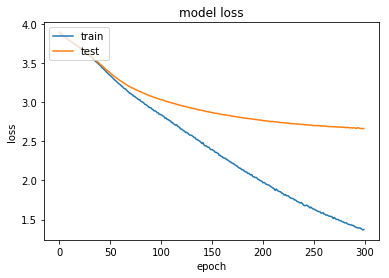

In [64]:
plot_loss()

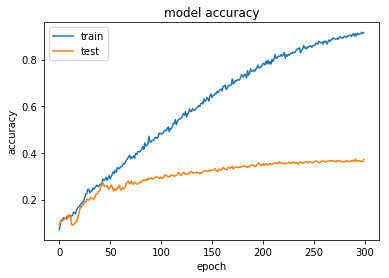

In [65]:
plot_acc()

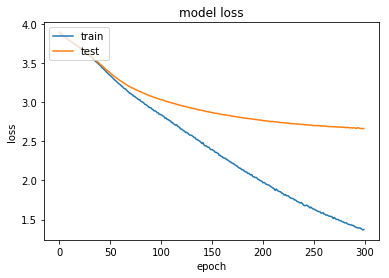

<Figure size 432x288 with 0 Axes>

In [75]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.figure()
fig.savefig('loss1.png')
# plt.show()




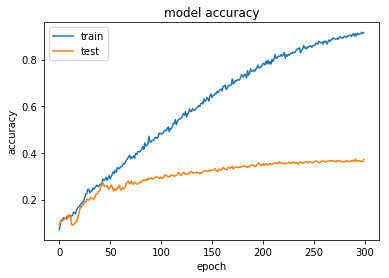

<Figure size 432x288 with 0 Axes>

In [71]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig = plt.figure()
fig.savefig('acc1.png')
# plt.show()